# Install and Prepare Enviroment


In [1]:
! pip install mediapipe==0.10.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
yfinance 0.2.59 requires protobuf<6,>=5.29.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [ ]:
# 📚 Basic Libraries for Numerical Operations
import numpy as np                                                              # For array operations and numerical calculations
from math import cos , sin                                                      # For trigonometric functions (cos, sin) drawing axes on face
import os                                                                       # For handling file and directory operations
import pickle                                                                   # For saving and loading trained models

# 📷 Image Processing Libraries
import cv2                                                                      # OpenCV for reading images, video processing, and drawing
import mediapipe as mp                                                          # MediaPipe for face landmark detection (lightweight and fast)
import scipy.io as sio                                                          # For reading .mat files (e.g., annotations from AFLW2000 dataset)

# 📈 Data Handling and Visualization
import pandas as pd                                                             # For handling tabular data (like .csv files)
import matplotlib.pyplot as plt                                                 # For plotting graphs and visualizing data


# 📚 Only needed if using Google Colab
from google.colab.patches import cv2_imshow                                     # To display images inside Google Colab

# 🧠 Machine Learning Regressors
from sklearn.multioutput import MultiOutputRegressor                            # For handling multi-output regression (pitch, yaw, roll)
from sklearn.svm import SVR                                                     # Support Vector Regression
from sklearn.ensemble import RandomForestRegressor                              # Random Forest model
from sklearn.ensemble import GradientBoostingRegressor                          # Gradient Descent-based Regression model
from sklearn.neighbors import KNeighborsRegressor                               # K-Nearest Neighbors model

# 🛠️ Model Training and Hyperparameter Tuning
from sklearn.model_selection import train_test_split                            # For splitting data into training and test sets
from sklearn.model_selection import GridSearchCV                                # For finding the best model hyperparameters

# 🧪 Model Evaluation Metrics
from sklearn.metrics import mean_squared_error                                  # For calculating Mean Squared Error (MSE)
from sklearn.metrics import mean_absolute_error                                 # For calculating Mean Absolute Error (MAE)


# Getting Data From Drive


In [ ]:
from google.colab import drive

drive.mount('/Datasets/')

Mounted at /Datasets/


In [ ]:
#getting a list of all files names and sorting it
files = os.listdir('/Datasets/MyDrive/Datasets/AFLW2000')
files.sort()

In [ ]:
# there is a folder called "Code" which is not needed, so it will be removed
del files[0]

In [ ]:
# there's two file types .jpg and .mat, we will create two seperate lists to hold the file names of each type
jpg_files = [name for name in files if name.split('.')[1] == 'jpg']
mat_files = [name for name in files if name.split('.')[1] == 'mat']

# Extracting Landmarks

Based on certain landmarks from the face such as the location of the nose, eyes, forhead, etc..., we can detect the 3 angles around the axes (x,y,z), those angles (pitch, yaw roll) can estimate the position of the head w.r.t to the axes. The location of each landmark can be described using its location on the x and y axis. So we want to extract the location of these features, in this section we will perform such that!

The mediapipe module provides a model that is able to detect the landmarks for us.

In [ ]:
# Load the Face Mesh model from MediaPipe so we can detect facial landmarks
face_module = mp.solutions.face_mesh

# Create empty lists to store landmarks and labels
X = []              # X-coordinates of landmarks
y = []              # Y-coordinates of landmarks
labels = []         # Pose parameters (pitch, yaw, roll)
image_names = []    # Image file names


# Go through each image and its matching .mat file
for img_path, mat_path in zip(jpg_files, mat_files):

    # Read the image
    img = cv2.imread('/Datasets/MyDrive/Datasets/AFLW2000/' + img_path)
    # Read the pose parameters from the mat file
    mat = sio.loadmat('/Datasets/MyDrive/Datasets/AFLW2000/' + mat_path)



    # Create a Face Mesh object to detect landmarks on a static image (not a video).
    # 'static_image_mode=True' tells it that the input is just a single image.
    # 'face_mesh' will be used to run the detection.
    with face_module.FaceMesh(static_image_mode=True) as face_mesh:

        # Convert the image from BGR (OpenCV default) to RGB (used by MediaPipe)
        # and then process it with the Face Mesh model to detect face landmarks.
        # The 'results' variable will store the detected landmarks and other info
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # check if face landmarks were detected
        if results.multi_face_landmarks:
            X_temp = []     # Temporary X-coordinates
            y_temp = []     # Temporary Y-coordinates


            # Get pose parameters (first three values: pitch, yaw, roll)
            pose_para = mat['Pose_Para'][0][:3]


            # Add the current image's file name (img_path) to the image_names list.
            image_names.append(img_path)


            # Loop through detected faces (usually just one face)
            for face_landmarks in results.multi_face_landmarks:

                # initialize array for this set of landmarks to get image size
                shape = img.shape

                # Loop through each landmark point
                for landmark in face_landmarks.landmark:

                    # Convert normalized coordinates to pixel values
                    # multiplying the normalized coordinate by the image dimension
                    # (width or height) converts it to actual pixel coordinates.

                    relative_x = int(landmark.x * shape[1])
                    relative_y = int(landmark.y * shape[0])

                    # Save the coordinates
                    # These converted pixel values are added to the temporary lists X_temp and y_temp for this specific image.
                    X_temp.append(relative_x)
                    y_temp.append(relative_y)

                # After extracting all landmarks' pixel coordinates, the entire list of landmarks
                # (stored in X_temp and y_temp) is added to the final lists X and y that store all image landmarks.
                X.append(X_temp)
                y.append(y_temp)

                # pose_para is a label containing the pose parameters (pitch, yaw, roll) for this image, and it is added to the labels list.
                labels.append(pose_para)

# Convert lists into numpy arrays
X = np.array(X)
y = np.array(y)
labels = np.array(labels)
image_names = np.array(image_names)


# Print shapes to check if everything is correct
print(X.shape)
print(y.shape)
print(labels.shape)
print(image_names.shape)

(1853, 468)
(1853, 468)
(1853, 3)
(1853,)


## Saving np Arrays

In [ ]:
# we will save the np arrays for easier loading
np.save('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/X_points.npy', X)
np.save('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/y_points.npy', y)
np.save('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/labels.npy', labels)
np.save('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/image_names.npy', image_names)

In [ ]:
# load the np arrays
X_points = np.load('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/X_points.npy')
y_points = np.load('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/y_points.npy')
labels = np.load('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/labels.npy')
image_names = np.load('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/image_names.npy')


# check shapes
print(X_points.shape)
print(y_points.shape)
print(labels.shape)
print(image_names.shape)

(1853, 468)
(1853, 468)
(1853, 3)
(1853,)


# Data Exploration & Visualization

In this section we aim to understand data furthermore, and to look at the detected landamrks in the first section, as well as visualizing the desired output for the project.

##Data Exploration

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    # """
    # Draws 3D coordinate axes on an image based on head pose angles: pitch, yaw, and roll.

    # Args:
    #     img: The image on which to draw.
    #     pitch: Head pitch angle (up/down movement).
    #     yaw: Head yaw angle (left/right movement).
    #     roll: Head roll angle (tilting sideways).
    #     tdx: x-coordinate for the origin of the axes (optional).
    #     tdy: y-coordinate for the origin of the axes (optional).
    #     size: Length of the axes lines.

    # Returns:
    #     The image with the drawn axes.
    # """

    # Invert yaw to align coordinate system with image display
    yaw = -yaw

    # Set center of drawing (origin point) to tdx, tdy if provided; else, center of the image
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2


    # ---- Calculate Endpoints of Each Axis ---- #

    # X-axis (Red): Right direction
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-axis (Green): Down direction
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-axis (Blue): Out of the screen direction
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    # ---- Draw Each Axis Line ---- #

    # cv2.line function
    # Draw a line on the image:
    # - img: image to draw on
    # - (int(tdx), int(tdy)): starting point (origin of axes)
    # - (int(x), int(y)): ending point (?-axis direction)
    # - (0, 0, 0): color in BGR format
    # - x : thickness of the line

    # Draw X-axis in RED from center to (x1, y1)
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    # Draw Y-axis in GREEN from center to (x2, y2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    # Draw Z-axis in BLUE from center to (x3, y3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    # Return the final image
    return img

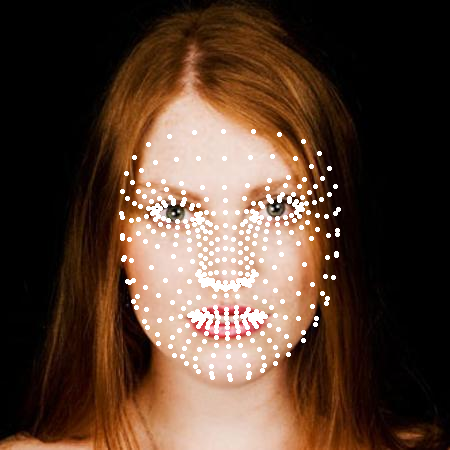

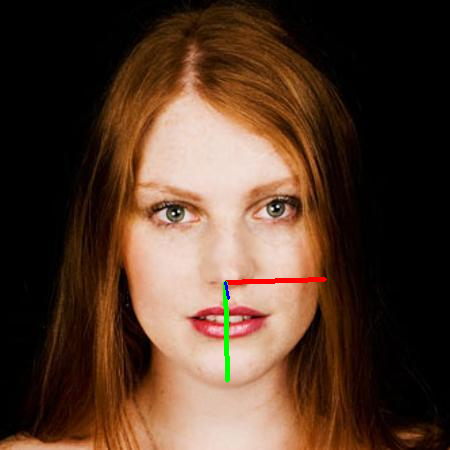

In [ ]:
# drawing the deteced landmarks and the actual labels (pitch, yaw, roll) for an image

index = 1310                                                                    # Load random image from the dataset at a specific index
img = cv2.imread('/Datasets/MyDrive/Datasets/AFLW2000/' + image_names[index])   # Read image
img_copy = img.copy()                                                           # Make a copy of the image to avoid modifying the original


# Iterate through the detected facial landmark coordinates (x and y) for the selected image
for relative_x1, relative_y1 in zip(X_points[index], y_points[index]):
  cv2.circle(img_copy, (relative_x1, relative_y1), radius=1, color=(255, 255, 255), thickness=2)
    # Draw a small white circle at each landmark coordinate on the copied image.
    # (relative_x, relative_y) is the center of the circle.
    # radius=1 sets the size of the circle.
    # color=(255, 255, 255) defines the circle color as white (in BGR format).
    # thickness=2 sets the thickness of the circle's border.

cv2_imshow(img_copy)                                                            # Display the copied image with the drawn facial landmarks.

cv2_imshow(draw_axis(img, labels[index][0], labels[index][1], labels[index][2], X_points[:, 1][index], y_points[:, 1][index]))
# Display the original image with an overlaid 3D axis representing the head pose (pitch, yaw, roll).
# draw_axis is assumed to be a custom function that takes:
# - the original image (img)
# - pitch (labels[index][0])
# - yaw (labels[index][1])
# - roll (labels[index][2]) - these are the ground truth pose labels for the image
# - X_points[:, 1][index] and y_points[:, 1][index] - likely the x and y coordinates of a specific facial landmark (e.g., the nose) used as a reference point for drawing the axis.

## Data Pre-processing

In [ ]:
# Print the minimum and maximum values of the X_points array.
# This helps understand the range of x-coordinates of the facial landmarks.
print('X points range from {} to {}'.format(X_points.min(), X_points.max()))

# Print the minimum and maximum values of the y_points array.
# This helps understand the range of y-coordinates of the facial landmarks.
print('y points range from {} to {}'.format(y_points.min(), y_points.max()))

# Print the minimum and maximum values of the labels array, formatted to two decimal places.
# This shows the range of the pose labels (pitch, yaw, roll).
print('Labels range from {:.2f} to {:.2f}'.format(labels.min(), labels.max()))

X points range from 4 to 488
y points range from -26 to 429
Labels range from -16.97 to 15.60


As seen, the range of the data is not the same scale, so the data need to be **Normalized**.

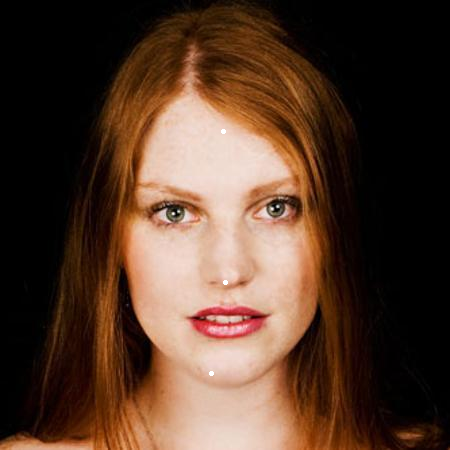

In [ ]:
# drawing certain landmarks from the image
index = 1310
img = cv2.imread('/Datasets/MyDrive/Datasets/AFLW2000/' + image_names[index])
# Draw a white circle at the coordinates of the landmark with index 1 for the selected image.
# X_points[index, 1] gets the x-coordinate, and y_points[index, 1] gets the y-coordinate.
cv2.circle(img, (X_points[index, 1], y_points[index, 1]), radius=1, color=(255, 255, 255), thickness=2)      #index 1 for Nose tip
# Draw a green circle at the coordinates of the landmark with index 10 for the selected image.
cv2.circle(img, (X_points[index, 10], y_points[index, 10]), radius=1, color=(255, 255, 255), thickness=2)    #index 10 for Forehead
# Draw a green circle at the coordinates of the landmark with index 171 for the selected image.
cv2.circle(img, (X_points[index, 171], y_points[index, 171]), radius=1, color=(255, 255, 255), thickness=2)  #index 171 for Chin
cv2_imshow(img)
# Display the image with the three highlighted landmarks.

As seen, the nose tip , the chin alongside the forehead are drawn on the image, we can use these three points to normailze our data.

We can subtract all points from the nose points, the nose point is a stable landmark that is typically used as a reference point, and subtracting it from the other landmarks can help to normalize their position and orientation.

Furthermore, by dividing the data by the distance from the chin to the forehead, the features become normalized to a standard size, and the scale of the features can be more easily compared. This is because the distance from the chin to the forehead is a measure of the size of the face, and by normalizing the data to this measure, features from faces of different sizes can be compared more fairly.

In [ ]:
# Normalizing features

# Centers all landmark x-coordinates by subtracting the nose's x-coordinate for each face.
#
# X_points: A 2D array where each row represents a face, and columns are the x-coordinates of its landmarks.
# X_points[:, 1]: Selects the x-coordinates of the landmark at index 1 (assumed to be the nose) for all faces.
# .reshape(-1, 1): Transforms the nose x-coordinates into a column vector. This allows for element-wise subtraction
#                 from the X_points array, where each nose x-coordinate is subtracted from all landmark x-coordinates
#                 of the corresponding face.
#
# The result, Nose_centered_X, is a new 2D array with the same shape as X_points, but the x-coordinates of all
# landmarks for each face are now relative to the x-coordinate of the nose of that face. This centering helps
# to normalize for the overall position of the face in the image.


Nose_centered_X = X_points - X_points[:, 1].reshape(-1, 1)

# Center the y-coordinates of all landmarks relative to the y-coordinate of the nose (assumed to be landmark index 1).
# Similar to the above, but for the y-coordinates.
Nose_centered_y = y_points - y_points[:, 1].reshape(-1, 1)

# Extract the x-coordinates of landmark index 171 for all images.
# Landmark 171 represents a point on the chin.
X_171 = X_points[:, 171]
# Extract the x-coordinates of landmark index 10 for all images.
# Landmark 10 represents a point on the forehead between the eyebrows.
X_10 = X_points[:, 10]
# Extract the y-coordinates of landmark index 171 for all images.
y_171 = y_points[:, 171]
# Extract the y-coordinates of landmark index 10 for all images.
y_10 = y_points[:, 10]

# Calculate the Euclidean distance between landmark 10 and landmark 171 for each image.
# np.array((X_10, y_10)) creates a 2xN array where N is the number of images.
# np.array((X_171, y_171)) creates another 2xN array.
# Subtracting these two arrays element-wise gives the difference in x and y coordinates for each pair of landmarks across all images.
# np.linalg.norm(..., axis=0) calculates the L2 norm (Euclidean distance) along the first axis (for each image).
# .reshape(-1, 1) reshapes the resulting 1xN array into a column vector (Nx1).
distance = np.linalg.norm(np.array((X_10, y_10)) - np.array((X_171, y_171)), axis=0).reshape(-1, 1)

# Normalize the centered x-coordinates by dividing by the calculated distance.
# This makes the scale of the x-coordinates invariant to the distance between the two reference landmarks.
Norm_X = Nose_centered_X / distance

# Normalize the centered y-coordinates by dividing by the calculated distance.
# This makes the scale of the y-coordinates invariant to the distance between the two reference landmarks.
Norm_Y = Nose_centered_y / distance

# Print the shape of the normalized x-coordinate array.
print(Norm_X.shape)
# Print the shape of the normalized y-coordinate array.
print(Norm_Y.shape)

# Concatenate the normalized x and y coordinates horizontally to create the feature matrix.
# np.hstack stacks arrays in sequence horizontally (column-wise).
features = np.hstack([Norm_X, Norm_Y])
# Print the shape of the resulting feature matrix. The number of columns will be twice the number of landmarks.
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


In [ ]:
# Print the minimum value across all elements in the 'features' array.
# This gives an idea of the lower bound of the normalized landmark coordinates.
print("Features Min. Value:", features.min())

# Print the maximum value across all elements in the 'features' array.
# This gives an idea of the upper bound of the normalized landmark coordinates.
print("Features Max. Value:", features.max())

Features Min. Value: -1.0061048346297883
Features Max. Value: 1.05004714400665


As seen now all the features range from -1 to 1.

# Modelling

Since we have 3 outputs "Yaw", "Pitch", "Roll", so we have a Multi-label problem, to solve this we should fit 3 models, each model should output each label, we could this manually or we could use sklearn's MultiOutputRegressor which automatically fits one model to each output.



To evaluate the different models and compare between them we will use MSE and RMSE. Lower, MSE and RMSE values indicate a better fit of the model. but RMSE has the same scale as our data, so it's easier to interpret.

In [ ]:
# train-test split
# Splits the dataset into training and testing sets.
#
# features: The input features (normalized landmark coordinates).
# labels: The target labels (pitch, yaw, roll angles).
#
# X_train: Features for the training set.
# X_test: Features for the testing set.
# y_train: Labels for the training set.
# y_test: Labels for the testing set.
#
# test_size=0.15: Specifies that 15% of the data will be used for the test set, and the remaining 85% for the training set.
# random_state=42: Sets a seed for the random number generator. This ensures that the split is the same every time the code is run, which is useful for reproducibility.
# shuffle=True: Indicates that the data will be shuffled randomly before splitting. This helps to ensure that the training and testing sets are representative of the overall distribution of the data.

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, test_size=0.15, shuffle=True)

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Evaluates the performance of a given machine learning model.
    #
    # Args:
    #   model: The trained machine learning model.
    #   X_train: The training features.
    #   y_train: The training labels.
    #   X_test: The testing features.
    #   y_test: The testing labels.
    #
    # Returns:
    #   None. Prints the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
    #   for both the training and testing datasets.

    # Make predictions on the training data.
    train_predictions = model.predict(X_train)
    # Make predictions on the testing data.
    predictions = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE) on the training data.
    # MSE measures the average squared difference between the predicted and actual values.
    train_MSE = mean_squared_error(y_train, train_predictions)
    # Calculate the Mean Squared Error (MSE) on the testing data.
    test_MSE = mean_squared_error(y_test, predictions)

    # Print the training MSE.
    print('Train MSE:', train_MSE)
    # Calculate the Root Mean Squared Error (RMSE) on the training data.
    # RMSE is the square root of the MSE and provides an error metric in the same units as the labels.
    print('Train RMSE:', np.sqrt(train_MSE))
    # Print the testing MSE.
    print("Test MSE:", test_MSE)
    # Calculate the Root Mean Squared Error (RMSE) on the testing data.
    print("Test RMSE:", np.sqrt(test_MSE))

In [ ]:
# fitting & evaluating a SVR model
#
# This section trains a Support Vector Regression (SVR) model for multi-output regression
# (predicting multiple continuous target variables: pitch, yaw, and roll).

# We chose SVR here instead of SVM (Support Vector Machine) because our task involves
# predicting continuous numerical values (the pose angles). SVM is primarily
# designed for discrete categories.
#
# The MultiOutputRegressor is used to handle the fact that we have multiple output variables
# (pitch, yaw, roll). It essentially trains an independent SVR model for each output.

SVR_model = MultiOutputRegressor(SVR())

# Train the SVR model using the training features (X_train) and the training labels (y_train).
# The fit method learns the mapping from the normalized landmark coordinates to the pose angles.
SVR_model.fit(X_train, y_train)

# Evaluate the trained SVR model using the evaluate_model function defined previously.
# This function calculates and prints the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
evaluate_model(SVR_model, X_train, y_train, X_test, y_test)


Train MSE: 0.22176723994448375
Train RMSE: 0.47092169194515104
Test MSE: 0.018560534123970386
Test RMSE: 0.1362370512157775


In [ ]:
# fitting & evaluating a KNN model
#
# This section trains a K-Nearest Neighbors (KNN) regression model for multi-output regression
# (predicting multiple continuous target variables: pitch, yaw, and roll).

# We use KNN here because it is a simple and intuitive non-parametric method
# that predicts the value of a data point based on the average of its K nearest neighbors.
# It is effective when the relationship between features and target variables is non-linear
# and when the data distribution supports local approximations.

# The MultiOutputRegressor is used to handle the fact that we have multiple output variables
# (pitch, yaw, roll). It trains an independent KNN regressor for each output.

# Initialize a MultiOutputRegressor with a KNeighborsRegressor base estimator.
# MultiOutputRegressor allows using single-output regressors (like KNN) for multi-output problems.
# KNeighborsRegressor() creates the base KNN regression model.
KNN_model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))

# Train the KNN model using the training features (X_train) and the training labels (y_train).
# The fit method learns the mapping from the normalized landmark coordinates to the pose angles.
KNN_model.fit(X_train, y_train)

# Evaluate the trained KNN model using the evaluate_model function defined previously.
# This function calculates and prints the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
# on both the training and testing sets, providing insight into the model's performance.
evaluate_model(KNN_model, X_train, y_train, X_test, y_test)


Train MSE: 0.17636682601212605
Train RMSE: 0.4199605053003509
Test MSE: 0.10627129871500034
Test RMSE: 0.3259927893604402


In [ ]:
# fitting & evaluating a RandomForestRegressor
# NOTE: MultiOutputRegressor is not explicitly used here because RandomForestRegressor
#       can inherently handle multi-output regression tasks. Each tree in the forest
#       can predict multiple output values simultaneously.

# Initialize a RandomForestRegressor model.
# RandomForestRegressor is an ensemble learning method that builds multiple decision trees
# and averages their predictions to improve accuracy and reduce overfitting.
RFC_model = RandomForestRegressor()

# Train the RandomForestRegressor model using the training features (X_train) and the training labels (y_train).
# The fit method builds the forest of decision trees based on the training data.
RFC_model.fit(X_train, y_train)

# Evaluate the trained RandomForestRegressor model using the evaluate_model function.
# This function calculates and prints the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
# on both the training and testing sets to assess the model's performance in predicting
# the pitch, yaw, and roll angles.
evaluate_model(RFC_model, X_train, y_train, X_test, y_test)

Train MSE: 0.03457232181259917
Train RMSE: 0.18593633806386306
Test MSE: 0.18325804279664082
Test RMSE: 0.42808648985531045


In [ ]:
# fitting & evaluating a GradientBoostingRegressor
#
# This section trains a Gradient Boosting Regressor model for multi-output regression
# (predicting the continuous values of pitch, yaw, and roll).
# Gradient Boosting is an ensemble learning technique that builds multiple decision trees sequentially,
# with each new tree trying to correct the errors made by the previous ones.
# MultiOutputRegressor is used here to handle the multiple output variables (pose angles).
#
# We used GradientBoostingRegressor instead of a direct "Gradient Descent Regressor" because:
# 1. Gradient Boosting is a powerful and well-established ensemble method that often achieves
#    high predictive accuracy by combining the strengths of many weak learners (decision trees).
# 2. GradientBoostingRegressor internally uses gradient descent to optimize the loss function
#    as it sequentially builds the decision trees. It's a specific implementation of a boosting
#    algorithm that leverages gradient descent principles.
# 3. For this type of structured data (facial landmarks to continuous pose angles), tree-based
#    ensemble methods like Gradient Boosting often perform very well due to their ability to
#    capture non-linear relationships and feature interactions.
#
# In essence, GradientBoostingRegressor is a high-level model that *uses* gradient descent
# internally during its training process, making it a more practical and effective choice
# for this regression task compared to trying to implement a basic gradient descent-based regressor directly.

# Initialize a MultiOutputRegressor with a GradientBoostingRegressor as the base estimator.
# MultiOutputRegressor allows us to apply a single-output regressor (GradientBoostingRegressor)
# to a multi-output problem.
GBR = MultiOutputRegressor(GradientBoostingRegressor())

# Train the Gradient Boosting Regressor model using the training features (X_train) and the training labels (y_train).
# The fit method trains the sequence of decision trees to learn the mapping from the normalized
# landmark coordinates to the pitch, yaw, and roll angles.
GBR.fit(X_train, y_train)

# Evaluate the trained Gradient Boosting Regressor model using the evaluate_model function.
# This function calculates and prints the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
# on both the training and testing sets. These metrics provide an assessment of how well the
# model predicts the pose angles and its ability to generalize to unseen data.
evaluate_model(GBR, X_train, y_train, X_test, y_test)

Train MSE: 0.00661600894686513
Train RMSE: 0.08133885262815754
Test MSE: 0.3444709095582507
Test RMSE: 0.5869164417174311


As seen the model with the lowest MSE and RMSE, is Support Vector Regressor, we should take this model, and optimize it a bit further, to try and get better results.

## Model Optimization

In [ ]:
# Define a list of label names corresponding to the output dimensions.
label_names = ['pitch', 'yaw', 'roll']
# Access the list of individual SVR models from the trained SVR_model (likely a MultiOutputRegressor).
svr_list = SVR_model.estimators_
# Iterate through the list of SVR models along with their index.
for i, model in enumerate(svr_list):
  # Print a header indicating which label's model is being evaluated.
  print(f'{label_names[i]} Model Evaluate')
  # Call a function to evaluate the current model.
  # It passes the model, training features (X_train), training target values for the current label (y_train[:, i]),
  # testing features (X_test), and testing target values for the current label (y_test[:, i]).
  evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])
  # Print a newline character to add spacing between the evaluation results of different models.
  print('\n')

pitch Model Evaluate
Train MSE: 0.28227482469716925
Train RMSE: 0.5312954213026584
Test MSE: 0.02096026343497217
Test RMSE: 0.14477659836787218


yaw Model Evaluate
Train MSE: 0.04841088951654326
Train RMSE: 0.22002474750932735
Test MSE: 0.01622018743105066
Test RMSE: 0.12735849964195817


roll Model Evaluate
Train MSE: 0.3346160056197387
Train RMSE: 0.5784600294054367
Test MSE: 0.018501151505888342
Test RMSE: 0.13601893804131962




Since we have 3 models, we shall optimize each one indivdually

In [ ]:
def svr_grid_search(X_train, y_train, params):
    #
    # Optimizes an SVR model's hyperparameters using GridSearchCV.

    # Args:
    #     X_train (array-like): Training data features.
    #     y_train (array-like): Training data target values.
    #     params (dict): Dictionary of hyperparameters to search.
    #         e.g., {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

    # Returns:
    #     SVR: The SVR model with the best found hyperparameters.
    #
    # 1. Create an SVR model instance.
    svr = SVR()

    # 2. Set up GridSearchCV for hyperparameter tuning.
      # Create a GridSearchCV object. This object performs an exhaustive search over specified
      # hyperparameter values for an estimator.  For each combination of hyperparameters,
      # it trains the SVR model, evaluates its performance using cross-validation,
      # and selects the hyperparameter combination that yields the best performance
      # according to the specified scoring metric.
      #
      #   - estimator: The model to optimize (SVR in this case).
      #   - param_grid: The dictionary of hyperparameters to search over.
      #   - scoring: The scoring metric to use for evaluating the models.
      #     'neg_mean_squared_error' is used because GridSearchCV tries to *maximize* the score,
      #     and MSE is an error, so we use its negative.
      #   - cv: The number of folds for cross-validation.The model will be trained and evaluated based on number of folds, each time using a different fold as the validation set.
      #   - n_jobs: The number of CPU cores to use for parallel process
    grid_search = GridSearchCV(
        estimator=svr,  # The model to tune (SVR).
        param_grid=params, # The hyperparameters and their possible values.
        scoring='neg_mean_squared_error', # Metric to optimize (negative MSE).
        cv=5,            # Number of cross-validation folds.
        n_jobs=-1       # Use all available CPU cores for parallel processing.
    )

    # 3. Perform the grid search on the training data.
    grid_search.fit(X_train, y_train)

    # 4. Extract the best model and its parameters.
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # 5. Print the best hyperparameters.
    print('Best parameters:', best_params)

    # 6. Return the best SVR model.
    return best_model


In [ ]:
# Performing grid-search for the pitch model to find the optimal hyperparameters.
# We define a dictionary 'params' containing the hyperparameter grid to search over.
params = {
    'kernel': ['poly', 'rbf'],      # The kernel function to be used ('poly' for polynomial, 'rbf' for radial basis function).
    'C': [0.1, 1, 10, 100],         # Regularization parameter. Smaller values indicate stronger regularization.
    'epsilon': [0.01, 0.1, 1],      # Epsilon in the epsilon-SVR model. It specifies the width of the epsilon-tube within which no penalty is associated with training losses.
    'gamma': ['scale', 'auto']      # Kernel coefficient. 'scale' uses 1 / (n_features * X.var()), 'auto' uses 1 / n_features.
}

# We then call the 'svr_grid_search' function, passing the training data (X_train),
# the target variable for pitch (the first column of y_train), and the hyperparameter grid 'params'.
# This function likely performs a grid search with Support Vector Regression (SVR)
# to find the best combination of hyperparameters based on some cross-validation strategy.
pitch_model = svr_grid_search(X_train, y_train[:, 0], params)

# After finding the best model through grid search, we evaluate its performance.
# The 'evaluate_model' function is called with the trained 'pitch_model',
# the training data and target (for assessing training performance), and the test data and target
# (for assessing the model's generalization ability on unseen data).
evaluate_model(pitch_model, X_train, y_train[:, 0], X_test, y_test[:, 0])

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Train MSE: 0.26811717441430993
Train RMSE: 0.5178003229183137
Test MSE: 0.01943121635132415
Test RMSE: 0.13939589789991724


In [ ]:
# Performing grid-search for the yaw model to find the optimal hyperparameters.
# We define a dictionary 'params' containing the hyperparameter grid to search over.
params = {
    'kernel': ['poly', 'rbf'],      # The kernel function to be used ('poly' for polynomial, 'rbf' for radial basis function).
    'C': [0.1, 1, 10, 100],         # Regularization parameter. Smaller values indicate stronger regularization.
    'epsilon': [0.01, 0.1, 1],       # Epsilon in the epsilon-SVR model. It specifies the width of the epsilon-tube within which no penalty is associated with training losses.
    'gamma': ['scale', 'auto']      # Kernel coefficient. 'scale' uses 1 / (n_features * X.var()), 'auto' uses 1 / n_features.
}

# We then call the 'svr_grid_search' function, passing the training data (X_train),
# the target variable for yaw (the second column of y_train), and the hyperparameter grid 'params'.
# This function likely performs a grid search with Support Vector Regression (SVR)
# to find the best combination of hyperparameters based on some cross-validation strategy.
yaw_model = svr_grid_search(X_train, y_train[:, 1], params)

# After finding the best model through grid search, we evaluate its performance.
# The 'evaluate_model' function is called with the trained 'yaw_model',
# the training data and target (for assessing training performance), and the test data and target
# (for assessing the model's generalization ability on unseen data).
evaluate_model(yaw_model, X_train, y_train[:, 1], X_test, y_test[:, 1])


Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Train MSE: 0.04189100131242329
Train RMSE: 0.20467291299149307
Test MSE: 0.008139816967899942
Test RMSE: 0.09022093419988479


In [ ]:
# Performing grid-search for the roll model to find the optimal hyperparameters.
# We define a dictionary 'params' containing the hyperparameter grid to search over.
params = {
    'kernel': ['poly', 'rbf'],      # The kernel function to be used ('poly' for polynomial, 'rbf' for radial basis function).
    'C': [0.1, 1, 10, 100],         # Regularization parameter. Smaller values indicate stronger regularization.
    'epsilon': [0.01, 0.1, 1],       # Epsilon in the epsilon-SVR model. It specifies the width of the epsilon-tube within which no penalty is associated with training losses.
    'gamma': ['scale', 'auto']      # Kernel coefficient. 'scale' uses 1 / (n_features * X.var()), 'auto' uses 1 / n_features.
}

# We then call the 'svr_grid_search' function, passing the training data (X_train),
# the target variable for roll (the third column of y_train), and the hyperparameter grid 'params'.
# This function likely performs a grid search with Support Vector Regression (SVR)
# to find the best combination of hyperparameters based on some cross-validation strategy.
roll_model = svr_grid_search(X_train, y_train[:, 2], params)

# After finding the best model through grid search, we evaluate its performance.
# The 'evaluate_model' function is called with the trained 'roll_model',
# the training data and target (for assessing training performance), and the test data and target
# (for assessing the model's generalization ability on unseen data).
evaluate_model(roll_model, X_train, y_train[:, 2], X_test, y_test[:, 2])

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Train MSE: 0.29317851969794323
Train RMSE: 0.5414596196374604
Test MSE: 0.015543634079256281
Test RMSE: 0.12467411150377725


## Saving Models

In [ ]:
# saving the model as a pikcle file
with open('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/pitch_model.pkl', 'wb') as f:
    pickle.dump(pitch_model, f)

with open('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/yaw_model.pkl', 'wb') as f:
    pickle.dump(yaw_model, f)

with open('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/roll_model.pkl', 'wb') as f:
    pickle.dump(roll_model, f)

# Predictions

So far we have done the following:



*   Obtained the landmarks of the face
*   Normalization
*   Trained different Models & Compared Between them
*   Optimized The best Models for Better Performance

In this section we will start making predictions on images, videos, and live prediction using a webcam.



In [ ]:
# function to detect landmarks for an image
def detect_landmarks(img):
  # set up face mesh module
  face_module = mp.solutions.face_mesh

  # initialize arrays for features
  X = []
  y = []

  # create face mesh object
  with face_module.FaceMesh(static_image_mode=True) as face_mesh:
      # process image for the face_mesh model
      results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      # check if face landmarks were detected
      if results.multi_face_landmarks:
          # get face landmarks for all detected faces
          for face_landmarks in results.multi_face_landmarks:
              # initialize array for this set of landmarks
              shape = img.shape
              for landmark in face_landmarks.landmark:
                  # get landmark coordinates and add them to X and y lists
                  relative_x = int(landmark.x * shape[1])
                  relative_y = int(landmark.y * shape[0])
                  X.append(relative_x)
                  y.append(relative_y)

  X = np.array([X])
  y = np.array([y])

  # Normalizing features
  Nose_centered_X = X - X[:,1].reshape(-1,1)
  Nose_centered_y = y - y[:,1].reshape(-1,1)

  X_171 = X[:,171]
  X_10 = X[:,10]
  y_171 = y[:,171]
  y_10 = y[:,10]
  distance = np.linalg.norm(np.array((X_10,y_10)) - np.array((X_171, y_171)),axis = 0).reshape(-1,1)
  Norm_X = Nose_centered_X / distance
  Norm_Y = Nose_centered_y / distance

  nose_x = X[:,1]
  nose_y = y[:,1]

  features = np.hstack([Norm_X,Norm_Y])

  return features, nose_x, nose_y


In [ ]:
def model_predict(pitch_model, yaw_model, roll_model, features):
  # making predictions
  pitch = pitch_model.predict(features)
  yaw = yaw_model.predict(features)
  roll = roll_model.predict(features)
  return pitch, yaw, roll

In [ ]:
def perform_prediction(pitch_model, yaw_model, roll_model, img):
  features, nose_x, nose_y = detect_landmarks(img)
  pitch, yaw, roll = model_predict(pitch_model, yaw_model, roll_model, features)
  frame = draw_axis(img, pitch, yaw, roll, nose_x, nose_y)
  return frame,pitch, yaw, roll

<ipython-input-10-f6982995092a>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-10-f6982995092a>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-10-f6982995092a>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-10-f6982995092a>:39: DeprecationWarning: Conve

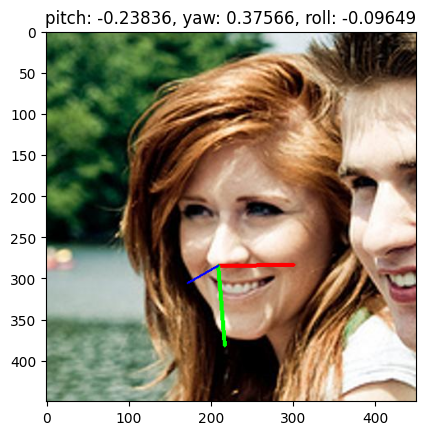

In [ ]:
# making predictions on random images from the web
test_images = '/Datasets/MyDrive/Datasets/AFLW2000/image00082.jpg'
# for image_name in os.listdir(test_images):
img = cv2.imread(test_images)



new_img,pitch,yaw,roll=perform_prediction(pitch_model, yaw_model, roll_model, img)

new_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


plt.imshow(new_img)


plt.title(f"pitch: {pitch[0]:.5f}, yaw: {yaw[0]:.5f}, roll: {roll[0]:.5f}")
plt.axis('on')
plt.show()

## Prediction on a Video

In [ ]:
# Open the input video file
cap = cv2.VideoCapture('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/Input Video.mp4')

# Get video properties
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the video codec and output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
out = cv2.VideoWriter('/Datasets/MyDrive/Datasets/FINALL Project(SVR ACCURATEE)/output.mp4', fourcc, frame_rate, (width, height))

# Function to overlay text on video frames
def draw_text(frame, pitch, yaw, roll):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    color = (0, 255, 0)  # Green color for text

    # Overlay pitch, yaw, and roll values
    cv2.putText(frame, f"Pitch: {pitch:.5f}", (50, 50), font, font_scale, color, font_thickness)
    cv2.putText(frame, f"Yaw: {yaw:.5f}", (50, 100), font, font_scale, color, font_thickness)
    cv2.putText(frame, f"Roll: {roll:.5f}", (50, 150), font, font_scale, color, font_thickness)

    return frame

# Process video frames
while True:
    try:
        # Read the next frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or cannot read the frame.")
            break

        # Perform prediction and get pitch, yaw, roll
        frame, pitch, yaw, roll = perform_prediction(pitch_model, yaw_model, roll_model, frame)
        pitch_value = float(pitch)  # Convert to scalar
        yaw_value = float(yaw)      # Convert to scalar
        roll_value = float(roll)    # Convert to scalar
        # Overlay pitch, yaw, and roll text on the frame
        frame = draw_text(frame, pitch_value, yaw_value, roll_value)

        # Write the processed frame to the output video
        out.write(frame)

    except Exception as e:
        print(f"Error processing frame: {e}")
        break

# Release resources
out.release()
cap.release()
print("Video processing completed.")

<ipython-input-10-f6982995092a>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-10-f6982995092a>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-10-f6982995092a>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-10-f6982995092a>:39: DeprecationWarning: Conve

Error processing frame: index 1 is out of bounds for axis 1 with size 0
Video processing completed.


<ipython-input-10-f6982995092a>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-10-f6982995092a>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-10-f6982995092a>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-10-f6982995092a>:39: DeprecationWarning: Conve